### Loading Zone Data from API

In [0]:
import requests
import json
import pandas as pd
zones = requests.get("https://api.covid19india.org/zones.json")
data = json.loads(zones.text)

Creating an empty dist to hold the district and zone details





In [0]:
# data['zones'][0]
# dist_zone_list=[]
dist_zone={}

Looping through the Json object district and zone to the dictionary in key value pair.

In [0]:
for entry in data['zones']:
  # dist_zone_list.append([entry['district'],entry['state'],entry['zone']])
  dist_zone.update({entry['district']:entry['zone']})

In [0]:
#dz_df=pd.DataFrame(dist_zone_list,columns=['district','state','zone'])

### Loading District Data from API

In [0]:
districts = requests.get("https://api.covid19india.org/districts_daily.json")
data_district = json.loads(districts.text)

In [0]:
#creating a list to store the extracted data from the json response
data_cnt=[]

Th function takes all the time series data for a district and returns the current number of cases and the day to today when the last increase in count was notices


```
Chitradurga		[31]
	0		{6}
notes	:	
active	:	0
confirmed	:	1
deceased	:	0
recovered	:	1
date	:	2020-04-24
	1		{6}
notes	:	
active	:	0
confirmed	:	1
deceased	:	0
recovered	:	1
date	:	2020-04-25
	2		{6}
notes	:	
active	:	0
confirmed	:	1
deceased	:	0
recovered	:	1
date	:	2020-04-26

```



In [0]:
from datetime import datetime
def getCaseAndLastReport(jsonObjectParam):
    cases_dist=pd.DataFrame(jsonObjectParam)
    current=cases_dist.max()
    current_cnf_cnt=current.confirmed
    current_dt=current.date
    previous=cases_dist[cases_dist['confirmed']<current_cnf_cnt].max()
    previous_cnf_cnt=previous.confirmed
    previous_dt=previous.date
    if(pd.isnull(previous_dt)):
      previous_dt='2020-04-21'
    datetime1=datetime.strptime(current_dt,'%Y-%m-%d')
    datetime2=datetime.strptime(previous_dt,'%Y-%m-%d')
    diff=(datetime1-datetime2).days
    return [diff,current_cnf_cnt]

Iterates through the json object and invokes the above function

In [0]:
for state in data_district['districtsDaily']:
  for district in data_district['districtsDaily'][state]:
    info=[state,district]
    val=getCaseAndLastReport(data_district['districtsDaily'][state][district])
    data_cnt.append(info+val)

Creating a dataframe from the list created

In [0]:
district_df=pd.DataFrame(data_cnt,columns=['State','District','DaysOfNoChange','Count'])

Applying map function on the dataframe and zone dictionary to get zone values in the district dataframe

In [0]:
district_df['zone']=district_df['District'].map(dist_zone)

In [0]:
#checking the obtained data for a specific state
district_df[district_df['State']=='West Bengal']

,State,District,DaysOfNoChange,Count,zone
781,West Bengal,Hooghly,2,191,Orange
782,West Bengal,Howrah,2,751,Red
783,West Bengal,Kalimpong,33,7,Orange
784,West Bengal,Kolkata,2,1613,Red
785,West Bengal,Medinipur East,10,22,NaN
786,West Bengal,Nadia,2,25,Orange
787,West Bengal,North 24 Parganas,2,445,Red
788,West Bengal,South 24 Parganas,2,120,Orange
789,West Bengal,Unknown,0,534,NaN
790,West Bengal,Darjeeling,5,10,Orange


In [0]:
#droping rows with null values
district_df.dropna(inplace=True)

In [0]:
#assigning codes to our zone color for the classifier algorithm to work on it
codes={'Red':1,'Orange':2,'Green':3}

In [0]:
district_df['zone_cd']=district_df['zone'].map(codes)

Representing the red, green and orange counts using bar chart

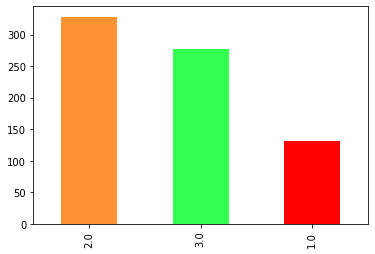

In [0]:

p=district_df.zone_cd.value_counts().plot(kind="bar",color=['#FF9233','#33FF53','#FF0000'])

Assigning X and y values for computation

In [0]:
X=district_df[['DaysOfNoChange','Count']].values
y = df['zone_cd'].values

In [0]:
X[0:5]

array([[ 33,   1],
       [ 30,  32],
       [ 33,   0],
       [  5, 136],
       [  5, 208]])

For the Clasification algorithm KNN to work well the mean should be zero and variance must be 1 hence normalizing the data is required

In [0]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

In [0]:
X

array([[ 1.85657699, -0.12798192],
       [ 1.6167601 , -0.10271815],
       [ 1.85657699, -0.12879688],
       ...,
       [ 1.85657699, -0.12879688],
       [ 1.85657699, -0.12879688],
       [ 1.85657699, -0.12879688]])

In [0]:
from sklearn.neighbors import KNeighborsClassifier

Splitting data into test and training set

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (588, 2) (588,)
Test set: (148, 2) (148,)


Considering K as 3 as we intend to divide the dataset into 3 groups

In [0]:
k = 3
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [0]:
#predicting Y based X_test
yhat = neigh.predict(X_test)

Calculating accuracy score gives an idea of the performance of our classification algorithm

In [0]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.7840136054421769
Test set Accuracy:  0.777027027027027


## Confusion matrix also gives as an estimate of the performace by comparing the predicted values to the actual values for the test dataset

In [0]:
#import confusion_matrix
from sklearn.metrics import confusion_matrix
#let us get the predictions using the classifier we had fit above
y_pred = neigh.predict(X_test)
confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,1.0,2.0,3.0,All
True,,,,
1.0,15,8,0,23
2.0,9,46,8,63
3.0,0,8,54,62
All,24,62,62,148


Text(0.5, 15.0, 'Predicted label')

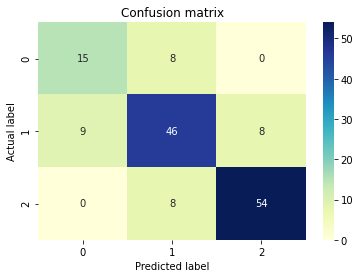

In [0]:
y_pred = neigh.predict(X_test)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Checking prediction on a small set of inputs

In [0]:
new_X=np.array([[ 33,   1],
       [ 30,  32],
       [ 21,   10],
       [  5, 106],
       [  5, 208]])
new_X=preprocessing.StandardScaler().fit(new_X).transform(new_X.astype(float))
ypred = neigh.predict(new_X)
ypred


array([1., 3., 2., 1., 1.])